# Goals for this model

Given a dataset of movie features, try to predict a movie's IMDB score before it is released.

# Todo List

- [X] collect each models' regression statistics into a dataframe for comparing models
- [X] test this script on predicting budget rather than score. do the results match moy's? is it easy to change the outcome variable?
- [ ] roll in the preprocessing steps to 
  - [ ] handle missing values
  - [X] cleanse data (e.g. parse country and release date, append release year to name)
  - [X] split data into new columns (release date to release year, month, day, etc.)
- [ ] apply GridSearchCV to each model
- [ ] apply automated feature selection to each model (backward elimination, forward selection)
- [ ] make many predictions and store results in a dataframe for comparing results (e.g. optimal runtime for horror movies is x )
- [ ] make normalization work for regression models (now that we have models other than linear regression we need it)

# About the Data

### Movie Industry | Four decades of movies

[via Daniel Grijalva on Kaggle](https://www.kaggle.com/danielgrijalvas/movies)

#### Context

Is the movie industry dying? is Netflix the new entertainment king? Those were the first questions that lead me to create a dataset
focused on movie revenue and analyze it over the last decades. But, why stop there? There are more factors that intervene in this
kind of thing, like actors, genres, user ratings and more. And now, anyone with experience (you) can ask specific questions about the
movie industry, and get answers.

#### Content

There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

- budget: the budget of a movie. Some movies don't have this, so it appears as 0
- company: the production company
- country: country of origin
- director: the director
- genre: main genre of the movie.
- gross: revenue of the movie
- name: name of the movie
- rating: rating of the movie (R, PG, etc.)
- released: release date (YYYY-MM-DD)
- runtime: duration of the movie
- score: IMDb user rating
- votes: number of user votes
- star: main actor/actress
- writer: writer of the movie
- year: year of release

### Acknowledgements

This data was scraped from IMDb.

# Imports

In [735]:
from pathlib import Path

import pandas as pd
import numpy as np
from patsy import dmatrices # https://pypi.org/project/patsy/

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression,Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR,SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor #Multi-layer Perceptron (not very powerful)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import explained_variance_score as explained_var, mean_absolute_error as mae, mean_squared_error as mse, mean_absolute_percentage_error as mape
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Collection of utility functions used in the book
# Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python (First Edition)
# Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel (c) 2019 John Wiley & Sons, Inc.
#
# Published under MIT License
# https://pypi.org/project/dmba/
# https://www.dataminingbook.com/book/python-edition.
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import backward_elimination, forward_selection, stepwise_selection, exhaustive_search
from dmba import adjusted_r2_score, AIC_score, BIC_score


# Base Inputs

In [736]:
# input definitions
fPath = '../../_data/_processed/'
fName = 'processed_for_viz.csv' # preprocessing already done
fName = 'BudgetImputed.csv' # output from Moy's processing script
#fPath = '../../_data/_raw/'
#fName = 'movies.csv' # original raw data
file = (fPath + fName) # preprocessing already done
continuous = True
outcome_var_name = 'budget'


# Read Data

In [737]:
# get data
df = pd.read_csv(fPath + fName)

# Basic Data Exploration

In [738]:
print('First few rows')
df.head(10)

First few rows


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
5,Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0
6,The Blues Brothers,R,Action,1980,"June 20, 1980 (United States)",7.9,188000.0,John Landis,Dan Aykroyd,John Belushi,United States,27000000.0,115229890.0,Universal Pictures,133.0
7,Raging Bull,R,Biography,1980,"December 19, 1980 (United States)",8.2,330000.0,Martin Scorsese,Jake LaMotta,Robert De Niro,United States,18000000.0,23402427.0,Chartoff-Winkler Productions,129.0
8,Superman II,PG,Action,1980,"June 19, 1981 (United States)",6.8,101000.0,Richard Lester,Jerry Siegel,Gene Hackman,United States,54000000.0,108185706.0,Dovemead Films,127.0
9,The Long Riders,R,Biography,1980,"May 16, 1980 (United States)",7.0,10000.0,Walter Hill,Bill Bryden,David Carradine,United States,10000000.0,15795189.0,United Artists,100.0


In [739]:
df.columns

Index(['name', 'rating', 'genre', 'year', 'released', 'score', 'votes',
       'director', 'writer', 'star', 'country', 'budget', 'gross', 'company',
       'runtime'],
      dtype='object')

## Column Preprocessing

In [740]:
def remove_column_name_special_chars(df):
    print('Replace special characters (spaces, etc) from column names')
    import re
    df.columns = [re.sub('[ |^&+\-%*/=!>]', '_', c) for c in df.columns ]
    return df

df = remove_column_name_special_chars(df)
df.columns

Replace special characters (spaces, etc) from column names


Index(['name', 'rating', 'genre', 'year', 'released', 'score', 'votes',
       'director', 'writer', 'star', 'country', 'budget', 'gross', 'company',
       'runtime'],
      dtype='object')

In [741]:
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


In [742]:
print('Basic Descriptive Statistics')
df.describe()

Basic Descriptive Statistics


,year,score,votes,budget,gross,runtime
count,7404.000000,7404.000000,7.404000e+03,7.404000e+03,7.404000e+03,7404.000000
mean,2000.636683,6.396569,9.082277e+04,3.018414e+07,7.902401e+07,107.438682
std,11.021332,0.962366,1.654105e+05,3.734078e+07,1.662593e+08,18.517094
min,1980.000000,1.900000,1.050000e+02,6.000000e+03,3.090000e+02,63.000000
25%,1991.000000,5.800000,1.000000e+04,9.000000e+06,4.637415e+06,95.000000
50%,2001.000000,6.500000,3.400000e+04,1.700000e+07,2.043974e+07,104.000000
75%,2010.000000,7.100000,9.600000e+04,3.500000e+07,7.647596e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


In [743]:
numeric_features = df.select_dtypes(['number']).columns
non_numeric_features = df.drop(columns=numeric_features).columns
print(numeric_features)
print(non_numeric_features)

Index(['year', 'score', 'votes', 'budget', 'gross', 'runtime'], dtype='object')
Index(['name', 'rating', 'genre', 'released', 'director', 'writer', 'star',
       'country', 'company'],
      dtype='object')


feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross - 0.00%
company - 0.00%
runtime - 0.00%


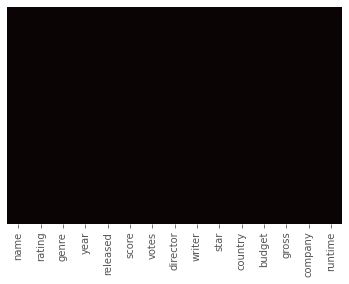

In [744]:
def list_missing(df):
    print('feature - % missing')
    print('-'*50)
    for col in df.columns:
        percent_missing = np.mean(df[col].isnull())
        print(f'{col} - {percent_missing*100:.2f}%')
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='mako')
    plt.show()

list_missing(df)

# Preprocessing

In [745]:
df_no_preprocessing = df.copy() # save off a copy of the data prior to preprocessing

### Handle Initial Data Cleaning

In [746]:
# rename gross to avoid confusion
df.rename(columns = {'gross' : 'gross_revenue'}, inplace=True)

In [747]:
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


In [748]:
# split released into columns for month, day, year

# split released
df[['release_month', 'release_day', 'release_year', 'other']] = df['released'].str.split(' ', n=3, expand=True)

df['release_day'] = df['release_day'].str.replace(',','') # loose the , in day and make it at int
# some of the values in 'released' are not full dates... drop those
months = ['June', 'July', 'May', 'December', 'October', 'September',
    'February', 'April', 'August', 'March', 'November', 'January']

df = df[df['release_month'].isin(months)]
df = df[df['release_day'].astype(int) <= 31]

df['release_day'] = df['release_day'].astype(int)
df['release_year'] = df['release_year'].astype(int)



In [749]:
# add other columns that are release date related

# rebuild a valid 'release date' column
from time import strptime
df['release_month_num'] = [strptime(str(x), '%B').tm_mon for x in df['release_month']]
df['release_date'] = pd.to_datetime(df['release_month_num'].astype(str) +'-'+ df['release_day'].astype(str) +'-'+ df['release_year'].astype(str))

# add a 'release quater' column
df['release_quarter'] = (df['release_month_num'].astype(int)-1)//3 + 1

# add 'release day of week' column
df['release_day_of_week'] = df['release_date'].dt.day_name()

# show that all release date related attributes are valid
print(df['release_day_of_week'].unique())
print(df['release_day'].unique())
print(df['release_year'].unique())

# show that quarter values are correctly mapped to months
print(df.groupby(['release_month_num', 'release_month','release_quarter']).size().reset_index().rename(columns={0:'count'}))


['Friday' 'Wednesday' 'Tuesday' 'Thursday' 'Saturday' 'Sunday' 'Monday']
[13  2 20 25  9 19 16 17 26 12  3  8 15 24  1 10 30 27 11 28 21  6 18 31
 14 22  4  5 23 29  7]
[1980 1981 1984 1983 1982 1987 1985 1986 1990 1988 1992 1989 1991 1999
 1994 1993 1995 2001 1996 2000 1997 1998 2002 2003 2004 2014 2005 2006
 2007 2008 2010 2009 2013 2011 2016 2015 2012 2017 2018 2019 2020]
    release_month_num release_month  release_quarter  count
0                   1       January                1    574
1                   2      February                1    580
2                   3         March                1    660
3                   4         April                2    621
4                   5           May                2    551
5                   6          June                2    544
6                   7          July                3    566
7                   8        August                3    713
8                   9     September                3    631
9                  10 

In [750]:
# Add a title field that has the release year appended to name

df['title'] = df['name'] + ' (' + df['release_year'].astype(str) + ')'

In [751]:
# Add Gross Profit etc
df['gross_profit'] = df['gross_revenue'] - df['budget']
df['profit_margin'] = df['gross_profit'] / df['budget']
df['profit_multiple'] = df['gross_revenue'] / df['budget']

In [752]:
# inspect final cleansed data
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
year,1980
released,"June 13, 1980 (United States)"
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson


### Handle Missing Values
TODO: Currently missing values are handled in Moy's preprocessing script and we're using output as this script's input

### Imput the average budget for the same genre and release year


Before Imput
feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross_revenue - 0.00%
company - 0.00%
runtime - 0.00%
release_month - 0.00%
release_day - 0.00%
release_year - 0.00%
other - 0.00%
release_month_num - 0.00%
release_date - 0.00%
release_quarter - 0.00%
release_day_of_week - 0.00%
title - 0.00%
gross_profit - 0.00%
profit_margin - 0.00%
profit_multiple - 0.00%


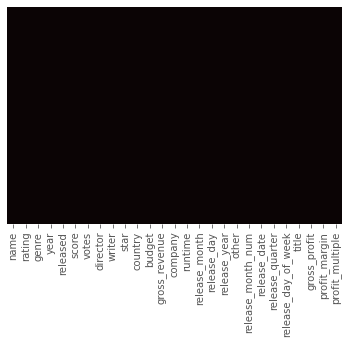

After Imput
feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross_revenue - 0.00%
company - 0.00%
runtime - 0.00%
release_month - 0.00%
release_day - 0.00%
release_year - 0.00%
other - 0.00%
release_month_num - 0.00%
release_date - 0.00%
release_quarter - 0.00%
release_day_of_week - 0.00%
title - 0.00%
gross_profit - 0.00%
profit_margin - 0.00%
profit_multiple - 0.00%


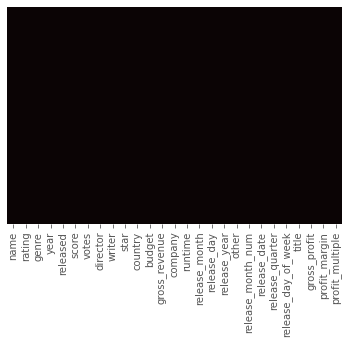

In [753]:
# only has an impact if na's still exist
print('Before Imput')
list_missing(df)
df['budget'].fillna(df.groupby(['genre','release_year'])['budget'].transform('mean'), inplace=True)
df['budget'].fillna(df.groupby(['release_year'])['budget'].transform('mean'), inplace=True)
df['budget'].fillna(df.groupby(['genre'])['budget'].transform('mean'), inplace=True)
print('After Imput')
list_missing(df) 

### Last resort is to imput the overall budget mean or median

#### Is budget normally distributed?

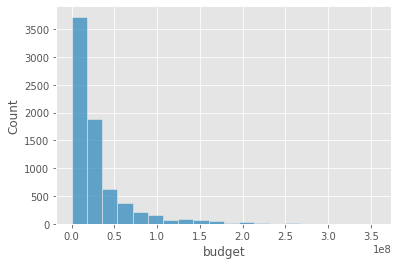

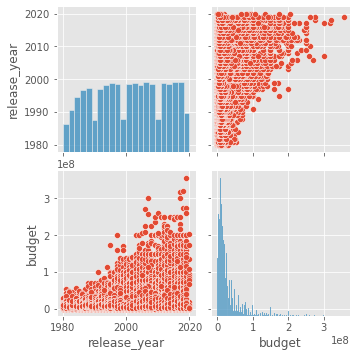

In [754]:
df_missing_budget = df[df['budget'].isna()]
df_have_budget = df[df['budget'].notna()]
sns.histplot(df_have_budget, x='budget', bins=20)

cols_to_plot = ['release_year', 'budget', 'genre']
sns.pairplot(df_have_budget[cols_to_plot])
plt.show()

No budgets are not normally distributed therefore we should not imput the overall mean.

It also seems clear that budgets rise over time. Maybe imputing the average budget for the release year will work.

In [755]:
df['budget'].fillna(df_have_budget['budget'].median(), inplace=True) # only has an impact if na's still exist

#### Drop any missing data rows that might still remain

feature - % missing
--------------------------------------------------
name - 0.00%
rating - 0.00%
genre - 0.00%
year - 0.00%
released - 0.00%
score - 0.00%
votes - 0.00%
director - 0.00%
writer - 0.00%
star - 0.00%
country - 0.00%
budget - 0.00%
gross_revenue - 0.00%
company - 0.00%
runtime - 0.00%
release_month - 0.00%
release_day - 0.00%
release_year - 0.00%
other - 0.00%
release_month_num - 0.00%
release_date - 0.00%
release_quarter - 0.00%
release_day_of_week - 0.00%
title - 0.00%
gross_profit - 0.00%
profit_margin - 0.00%
profit_multiple - 0.00%


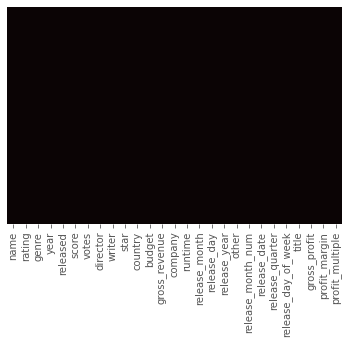

In [756]:
# if we couldn't imput missing budget values then drop the column
if np.mean(df['budget'].isnull()) > 0:
    df = df.drop(columns=['budget'])

# Since there is a small % of missing data for the remaining columns, we will drop all rows with any null values
df = df.dropna(how='any',axis=0)

#double check and confirm there is NO null value in the data
list_missing(df)

### Handle Final Data Cleansing


In [757]:
# Drop unwanted columns
try:
    df.drop(columns=['other', 'released', 'year'], inplace=True) #drop columns we don't need anymore
except:
    print('Nothing dropped. Columns referenced are not in the data. Have you already run this?')


In [758]:
#Drop bad data
df = df.loc[df['budget'] >= 0] #budget can't be negative drop anything with a negative budget


In [759]:
#Drop duplicates
df.drop_duplicates()

,name,rating,genre,score,votes,director,writer,star,country,budget,...,release_day,release_year,release_month_num,release_date,release_quarter,release_day_of_week,title,gross_profit,profit_margin,profit_multiple
0,The Shining,R,Drama,8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,1.900000e+07,...,13,1980,6,1980-06-13,2,Friday,The Shining (1980),2.799877e+07,1.473620,2.473620
1,The Blue Lagoon,R,Adventure,5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4.500000e+06,...,2,1980,7,1980-07-02,3,Wednesday,The Blue Lagoon (1980),5.435311e+07,12.078468,13.078468
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,1.800000e+07,...,20,1980,6,1980-06-20,2,Friday,Star Wars: Episode V - The Empire Strikes Back...,5.203751e+08,28.909726,29.909726
3,Airplane!,PG,Comedy,7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3.500000e+06,...,2,1980,7,1980-07-02,3,Wednesday,Airplane! (1980),7.995354e+07,22.843868,23.843868
4,Caddyshack,R,Comedy,7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6.000000e+06,...,25,1980,7,1980-07-25,3,Friday,Caddyshack (1980),3.384634e+07,5.641057,6.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,Wonder Woman 1984,PG-13,Action,5.4,217000.0,Patty Jenkins,Patty Jenkins,Gal Gadot,United States,1.075850e+08,...,25,2020,12,2020-12-25,4,Friday,Wonder Woman 1984 (2020),5.894903e+07,0.547930,1.547930
7400,Onward,PG,Animation,7.4,120000.0,Dan Scanlon,Dan Scanlon,Tom Holland,United States,6.773000e+07,...,6,2020,3,2020-03-06,1,Friday,Onward (2020),7.422061e+07,1.095831,2.095831
7401,The Quarry,R,Crime,5.4,2400.0,Scott Teems,Scott Teems,Shea Whigham,United States,4.435112e+06,...,17,2020,4,2020-04-17,2,Friday,The Quarry (2020),-4.431451e+06,-0.999175,0.000825
7402,Tulsa,PG-13,Comedy,5.0,294.0,Scott Pryor,Scott Pryor,Scott Pryor,United States,7.236143e+06,...,3,2020,6,2020-06-03,2,Wednesday,Tulsa (2020),-6.822765e+06,-0.942873,0.057127


In [760]:
# inspect data one last time
df.head(1).T

,0
name,The Shining
rating,R
genre,Drama
score,8.4
votes,927000.0
director,Stanley Kubrick
writer,Stephen King
star,Jack Nicholson
country,United Kingdom
budget,19000000.0


In [761]:
df_preprocessed = df.copy() # save off a copy of the data after preprocessing (this should be the data to be used for data viz)
#df_preprocessed.to_csv('preprocessing_done.csv')

# Feature Selection

### Drop very unique non-numeric columns

Categorical data with many unique values cause issues with converted to dummy variables

In [762]:
numeric_features = df.select_dtypes(['number']).columns
non_numeric_features = df.drop(columns=numeric_features).columns
print(numeric_features)
print(non_numeric_features)

Index(['score', 'votes', 'budget', 'gross_revenue', 'runtime', 'release_day',
       'release_year', 'release_month_num', 'release_quarter', 'gross_profit',
       'profit_margin', 'profit_multiple'],
      dtype='object')
Index(['name', 'rating', 'genre', 'director', 'writer', 'star', 'country',
       'company', 'release_month', 'release_date', 'release_day_of_week',
       'title'],
      dtype='object')


In [763]:
print('Unique Counts')
unique_counts = df.drop(columns=numeric_features).nunique(axis=0).sort_values()
very_unique_cols = unique_counts[unique_counts > 60].index

print(unique_counts)

Unique Counts
release_day_of_week       7
rating                    9
release_month            12
genre                    15
country                  57
company                2216
star                   2622
director               2802
release_date           2822
writer                 4330
name                   7213
title                  7356
dtype: int64


In [764]:
df.drop(columns=very_unique_cols, inplace=True)
df

,rating,genre,score,votes,country,budget,gross_revenue,runtime,release_month,release_day,release_year,release_month_num,release_quarter,release_day_of_week,gross_profit,profit_margin,profit_multiple
0,R,Drama,8.4,927000.0,United Kingdom,1.900000e+07,46998772.0,146.0,June,13,1980,6,2,Friday,2.799877e+07,1.473620,2.473620
1,R,Adventure,5.8,65000.0,United States,4.500000e+06,58853106.0,104.0,July,2,1980,7,3,Wednesday,5.435311e+07,12.078468,13.078468
2,PG,Action,8.7,1200000.0,United States,1.800000e+07,538375067.0,124.0,June,20,1980,6,2,Friday,5.203751e+08,28.909726,29.909726
3,PG,Comedy,7.7,221000.0,United States,3.500000e+06,83453539.0,88.0,July,2,1980,7,3,Wednesday,7.995354e+07,22.843868,23.843868
4,R,Comedy,7.3,108000.0,United States,6.000000e+06,39846344.0,98.0,July,25,1980,7,3,Friday,3.384634e+07,5.641057,6.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,PG-13,Action,5.4,217000.0,United States,1.075850e+08,166534027.0,151.0,December,25,2020,12,4,Friday,5.894903e+07,0.547930,1.547930
7400,PG,Animation,7.4,120000.0,United States,6.773000e+07,141950608.0,102.0,March,6,2020,3,1,Friday,7.422061e+07,1.095831,2.095831
7401,R,Crime,5.4,2400.0,United States,4.435112e+06,3661.0,98.0,April,17,2020,4,2,Friday,-4.431451e+06,-0.999175,0.000825
7402,PG-13,Comedy,5.0,294.0,United States,7.236143e+06,413378.0,120.0,June,3,2020,6,2,Wednesday,-6.822765e+06,-0.942873,0.057127


### Correlation

Rule of thumb for strength of correlation [via statology](https://www.statology.org/what-is-a-strong-correlation/)

|Absolute value of r | Strength of relationship|
|----|----|
|r < 0.25 | No relationship|
|0.25 < r < 0.5 | Weak relationship|
|0.5 < r < 0.75 | Moderate relationship|
|r > 0.75 | Strong relationship|

In [765]:
def correlation_analysis(df, method='pearson'):
    correlations = df.corr(method=method)
    
    # clustermap
    plt.figure(figsize=(14,12))
    sns.clustermap(correlations, cmap='mako_r', annot=True, vmin=0.25)
    plt.show()
    
    #pairplot
    #sns.pairplot(df, kind="reg", hue= outcome_var)

    # classify the correlations by rule of thumb
    corr_unpiv = correlations.melt(
        ignore_index=False, 
        var_name='var_2', 
        value_name='correlation').reset_index().rename(columns = {'index':'var_1'}).sort_values(by='correlation', ascending=False)
    corr_unpiv['correlation'] = abs(corr_unpiv['correlation'])
    corr_unpiv = corr_unpiv[corr_unpiv.var_1 != corr_unpiv.var_2] # don't want to show relationships with self
    corr_unpiv.drop_duplicates(subset='correlation', inplace=True) # drop rows the report the inverse duplicates <- not an optimal method

    strong = .75
    moderate = .50
    weak = .25
    corr_unpiv['relationship'] = 'Strong'
    corr_unpiv.loc[corr_unpiv['correlation'] < strong, 'relationship'] = 'Moderate'
    corr_unpiv.loc[corr_unpiv['correlation'] < moderate, 'relationship'] = 'Weak'
    corr_unpiv.loc[corr_unpiv['correlation'] < weak, 'relationship'] = 'None'

    strong = corr_unpiv[corr_unpiv['relationship'] == 'Strong']
    moderate = corr_unpiv[corr_unpiv['relationship'] == 'Moderate']
    weak = corr_unpiv[corr_unpiv['relationship'] == 'Weak']
    no_rel = corr_unpiv[corr_unpiv['relationship'] == 'None']
    print(strong)
    print('-'*75)
    print(moderate)
    print('-'*75)
    print(weak)
    print('-'*75)


<Figure size 1008x864 with 0 Axes>

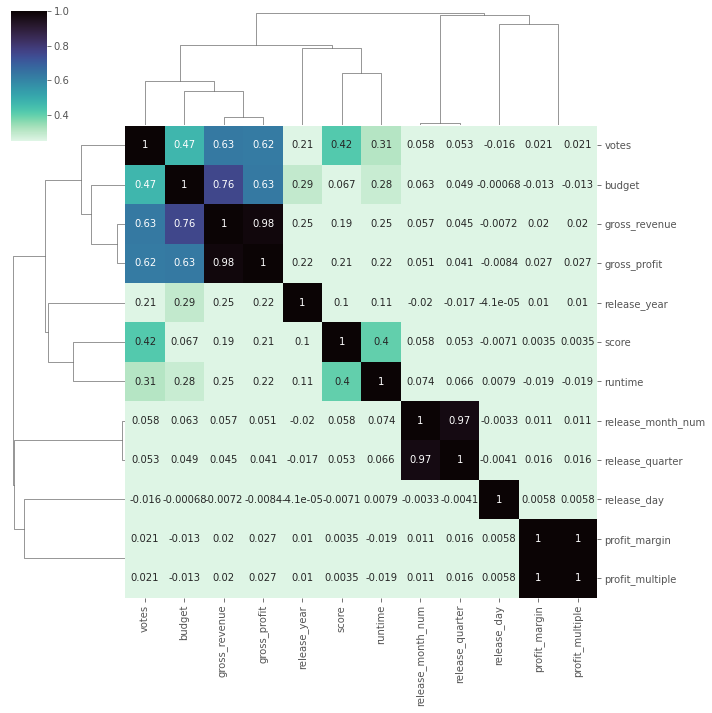

                 var_1            var_2  correlation relationship
142      profit_margin  profit_multiple     1.000000       Strong
45        gross_profit    gross_revenue     0.984707       Strong
103  release_month_num  release_quarter     0.971491       Strong
27       gross_revenue           budget     0.756213       Strong
---------------------------------------------------------------------------
            var_1   var_2  correlation relationship
33   gross_profit  budget     0.630653     Moderate
15  gross_revenue   votes     0.630471     Moderate
21   gross_profit   votes     0.622808     Moderate
---------------------------------------------------------------------------
           var_1          var_2  correlation relationship
14        budget          votes     0.469338         Weak
12         score          votes     0.417749         Weak
48         score        runtime     0.398534         Weak
16       runtime          votes     0.310627         Weak
74        budget   r

In [766]:
correlation_analysis(df)

<Figure size 1008x864 with 0 Axes>

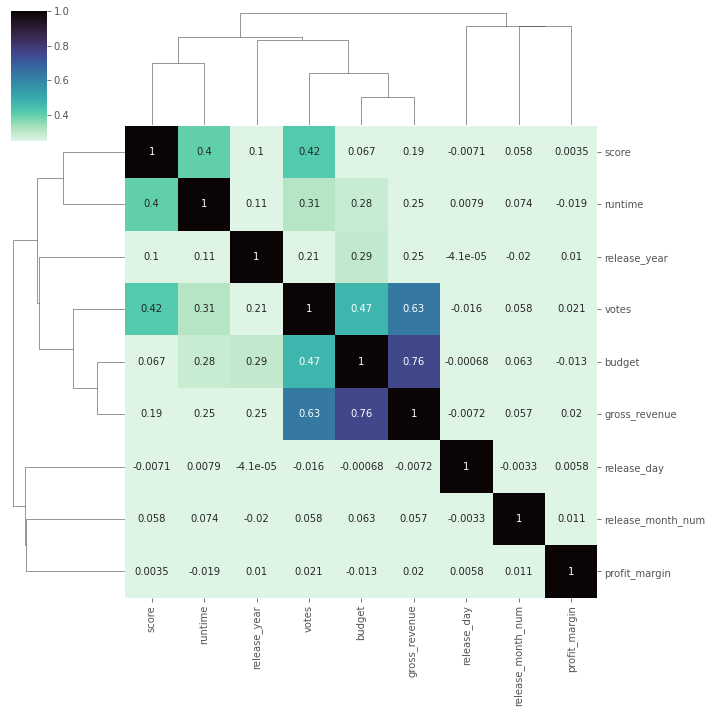

     var_1          var_2  correlation relationship
29  budget  gross_revenue     0.756213       Strong
---------------------------------------------------------------------------
            var_1  var_2  correlation relationship
12  gross_revenue  votes     0.630471     Moderate
---------------------------------------------------------------------------
           var_1          var_2  correlation relationship
11        budget          votes     0.469338         Weak
1          votes          score     0.417749         Weak
36         score        runtime     0.398534         Weak
37         votes        runtime     0.310627         Weak
56        budget   release_year     0.292740         Weak
22       runtime         budget     0.283661         Weak
33  release_year  gross_revenue     0.250587         Weak
---------------------------------------------------------------------------


In [767]:
dropped_for_correlation = ['profit_multiple', 'gross_profit', 'release_month', 'release_quarter', 'gross_revenue', 'votes']
dropped_for_correlation = ['profit_multiple', 'gross_profit', 'release_month', 'release_quarter', ] # Keeps fields that are in Moy's imputing model. doing this to confirm same results between files.

correlation_analysis(df.drop(columns=dropped_for_correlation))

In [768]:
df.drop(columns=dropped_for_correlation, inplace=True) # commit to the drop
df

,rating,genre,score,votes,country,budget,gross_revenue,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,R,Drama,8.4,927000.0,United Kingdom,1.900000e+07,46998772.0,146.0,13,1980,6,Friday,1.473620
1,R,Adventure,5.8,65000.0,United States,4.500000e+06,58853106.0,104.0,2,1980,7,Wednesday,12.078468
2,PG,Action,8.7,1200000.0,United States,1.800000e+07,538375067.0,124.0,20,1980,6,Friday,28.909726
3,PG,Comedy,7.7,221000.0,United States,3.500000e+06,83453539.0,88.0,2,1980,7,Wednesday,22.843868
4,R,Comedy,7.3,108000.0,United States,6.000000e+06,39846344.0,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7399,PG-13,Action,5.4,217000.0,United States,1.075850e+08,166534027.0,151.0,25,2020,12,Friday,0.547930
7400,PG,Animation,7.4,120000.0,United States,6.773000e+07,141950608.0,102.0,6,2020,3,Friday,1.095831
7401,R,Crime,5.4,2400.0,United States,4.435112e+06,3661.0,98.0,17,2020,4,Friday,-0.999175
7402,PG-13,Comedy,5.0,294.0,United States,7.236143e+06,413378.0,120.0,3,2020,6,Wednesday,-0.942873


We now have eliminated highly and moderately correlated features from our data.

### Multicollinearity

Calculate variance inflation factor (VIF)

[ref: statology](https://www.statology.org/how-to-calculate-vif-in-python/)

[ref: medium](https://medium.com/@analyttica/what-is-the-variance-inflation-factor-vif-d1dc12bb9cf5)

In [769]:
def multicollinearity_analysis(df):
    # find design matrix
    tested_features = df.drop(columns=outcome_var_name).columns
    tested_features = '+'.join(tested_features)

    df_sample = df.sample(frac=1, replace=True, random_state=1) # this allows us to runs VIF on just a sample if the dataset and/or tested features list is large

    y, X = dmatrices(f'{outcome_var_name} ~ {tested_features}', data=df_sample, return_type='dataframe')

    # calculate VIF for each explanatory variable (LONG PROCESS)
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable'] = X.columns

    # view VIF for each explanatory variable 
    moderate_thresh = 1.5 # sometimes 2
    high_thresh = 5

    vif['degree'] = 'High'
    vif.loc[vif['VIF'] < high_thresh, 'degree'] = 'Moderate'
    vif.loc[vif['VIF'] < moderate_thresh, 'degree'] = 'Low'

    high_vif = vif[vif['degree'] == 'High']
    moderate_vif = vif[vif['degree'] == 'Moderate']
    low_vif = vif[vif['degree'] == 'Low']


    print(high_vif)
    print(moderate_vif)


In [770]:
multicollinearity_analysis(df)

             VIF                   variable degree
0   42733.341092                  Intercept   High
3       7.957146               rating[T.PG]   High
4      12.552238            rating[T.PG-13]   High
5      15.144543                rating[T.R]   High
24     15.739270       country[T.Australia]   High
28     27.973522          country[T.Canada]   High
30      6.230500           country[T.China]   High
36     38.930446          country[T.France]   High
37     17.566335         country[T.Germany]   High
39      7.858380       country[T.Hong Kong]   High
42     11.942742           country[T.India]   High
45      8.352307         country[T.Ireland]   High
47      9.519302           country[T.Italy]   High
49     12.611011           country[T.Japan]   High
64      6.695724     country[T.South Korea]   High
65      9.355419           country[T.Spain]   High
72    115.644266  country[T.United Kingdom]   High
73    243.042452   country[T.United States]   High
         VIF                   

In [771]:
dropped_for_multicollinearity = ['country', 'rating']
dropped_for_multicollinearity = ['country'] # Keeps fields that are in Moy's imputing model. doing this to confirm same results between files.

multicollinearity_analysis(df.drop(columns=dropped_for_multicollinearity))


            VIF         variable degree
0  40006.262825        Intercept   High
3      7.796630     rating[T.PG]   High
4     12.249783  rating[T.PG-13]   High
5     14.839253      rating[T.R]   High
         VIF             variable    degree
2   3.123048  rating[T.Not Rated]  Moderate
10  1.779018   genre[T.Animation]  Moderate
12  1.851132      genre[T.Comedy]  Moderate
14  1.704779       genre[T.Drama]  Moderate
29  1.559779                score  Moderate
30  2.049844                votes  Moderate
31  1.994920        gross_revenue  Moderate


In [772]:
df.drop(columns=dropped_for_multicollinearity, inplace=True) # commit to the drop

In [773]:
print(df.columns)
df

Index(['rating', 'genre', 'score', 'votes', 'budget', 'gross_revenue',
       'runtime', 'release_day', 'release_year', 'release_month_num',
       'release_day_of_week', 'profit_margin'],
      dtype='object')


,rating,genre,score,votes,budget,gross_revenue,runtime,release_day,release_year,release_month_num,release_day_of_week,profit_margin
0,R,Drama,8.4,927000.0,1.900000e+07,46998772.0,146.0,13,1980,6,Friday,1.473620
1,R,Adventure,5.8,65000.0,4.500000e+06,58853106.0,104.0,2,1980,7,Wednesday,12.078468
2,PG,Action,8.7,1200000.0,1.800000e+07,538375067.0,124.0,20,1980,6,Friday,28.909726
3,PG,Comedy,7.7,221000.0,3.500000e+06,83453539.0,88.0,2,1980,7,Wednesday,22.843868
4,R,Comedy,7.3,108000.0,6.000000e+06,39846344.0,98.0,25,1980,7,Friday,5.641057
...,...,...,...,...,...,...,...,...,...,...,...,...
7399,PG-13,Action,5.4,217000.0,1.075850e+08,166534027.0,151.0,25,2020,12,Friday,0.547930
7400,PG,Animation,7.4,120000.0,6.773000e+07,141950608.0,102.0,6,2020,3,Friday,1.095831
7401,R,Crime,5.4,2400.0,4.435112e+06,3661.0,98.0,17,2020,4,Friday,-0.999175
7402,PG-13,Comedy,5.0,294.0,7.236143e+06,413378.0,120.0,3,2020,6,Wednesday,-0.942873


We have now dropped highly multicollinear fields from our data

### Drop fields that can't be known at time of prediction

If the model is being used for the purpose of imputing missing data then skip this step.
But if it's intended to be used for new predictions, we can't provide it with data that doesn't exist yet.

**The outcome variable field should not be dropped.**

In [774]:
print(f'Outcome variable is \'{outcome_var_name}\'. Don\'t drop it!')

Outcome variable is 'budget'. Don't drop it!


In [775]:
dropped_for_unknown_at_prediction = ['profit_margin']
df.drop(columns=dropped_for_unknown_at_prediction, inplace=True)
df

,rating,genre,score,votes,budget,gross_revenue,runtime,release_day,release_year,release_month_num,release_day_of_week
0,R,Drama,8.4,927000.0,1.900000e+07,46998772.0,146.0,13,1980,6,Friday
1,R,Adventure,5.8,65000.0,4.500000e+06,58853106.0,104.0,2,1980,7,Wednesday
2,PG,Action,8.7,1200000.0,1.800000e+07,538375067.0,124.0,20,1980,6,Friday
3,PG,Comedy,7.7,221000.0,3.500000e+06,83453539.0,88.0,2,1980,7,Wednesday
4,R,Comedy,7.3,108000.0,6.000000e+06,39846344.0,98.0,25,1980,7,Friday
...,...,...,...,...,...,...,...,...,...,...,...
7399,PG-13,Action,5.4,217000.0,1.075850e+08,166534027.0,151.0,25,2020,12,Friday
7400,PG,Animation,7.4,120000.0,6.773000e+07,141950608.0,102.0,6,2020,3,Friday
7401,R,Crime,5.4,2400.0,4.435112e+06,3661.0,98.0,17,2020,4,Friday
7402,PG-13,Comedy,5.0,294.0,7.236143e+06,413378.0,120.0,3,2020,6,Wednesday


In [776]:
dropped_for_missing_from_moy_file = ['release_day', 'release_year', 'release_month_num', 'release_day_of_week']
df.drop(columns=dropped_for_missing_from_moy_file, inplace=True)
df

,rating,genre,score,votes,budget,gross_revenue,runtime
0,R,Drama,8.4,927000.0,1.900000e+07,46998772.0,146.0
1,R,Adventure,5.8,65000.0,4.500000e+06,58853106.0,104.0
2,PG,Action,8.7,1200000.0,1.800000e+07,538375067.0,124.0
3,PG,Comedy,7.7,221000.0,3.500000e+06,83453539.0,88.0
4,R,Comedy,7.3,108000.0,6.000000e+06,39846344.0,98.0
...,...,...,...,...,...,...,...
7399,PG-13,Action,5.4,217000.0,1.075850e+08,166534027.0,151.0
7400,PG,Animation,7.4,120000.0,6.773000e+07,141950608.0,102.0
7401,R,Crime,5.4,2400.0,4.435112e+06,3661.0,98.0
7402,PG-13,Comedy,5.0,294.0,7.236143e+06,413378.0,120.0


# Train Models

### Generate dummies

In [777]:
X = pd.get_dummies(df.drop(columns=outcome_var_name), drop_first=True)
y = df[outcome_var_name]

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7357 entries, 0 to 7403
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   score             7357 non-null   float64
 1   votes             7357 non-null   float64
 2   gross_revenue     7357 non-null   float64
 3   runtime           7357 non-null   float64
 4   rating_NC-17      7357 non-null   uint8  
 5   rating_Not Rated  7357 non-null   uint8  
 6   rating_PG         7357 non-null   uint8  
 7   rating_PG-13      7357 non-null   uint8  
 8   rating_R          7357 non-null   uint8  
 9   rating_TV-MA      7357 non-null   uint8  
 10  rating_Unrated    7357 non-null   uint8  
 11  rating_X          7357 non-null   uint8  
 12  genre_Adventure   7357 non-null   uint8  
 13  genre_Animation   7357 non-null   uint8  
 14  genre_Biography   7357 non-null   uint8  
 15  genre_Comedy      7357 non-null   uint8  
 16  genre_Crime       7357 non-null   uint8  


### Normalization

In [778]:
# TODO: Not implemented

normalize = False

### Variance Inflation Factor (VIF)

In [779]:
drop = X.drop(['score', 'runtime'], axis=1)
vif_data = pd.DataFrame()
vif_data['feature'] = drop.columns
vif_data['VIF'] = [variance_inflation_factor(drop.values, col) for col in range(len(drop.columns))]

# Drop if 5 or greater
vif_data.sort_values('VIF', ascending=False)

,feature,VIF
6,rating_R,2.973961
1,gross_revenue,2.373232
13,genre_Comedy,2.324974
0,votes,2.255468
5,rating_PG-13,2.233109
15,genre_Drama,1.886499
4,rating_PG,1.854468
14,genre_Crime,1.370825
10,genre_Adventure,1.273499
12,genre_Biography,1.260094


In [780]:
X.drop(['score', 'runtime'], axis=1, inplace=True)


### Split Data

In [781]:
# partition data
test_size = 0.3
print(f'test size: {test_size}')
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=test_size, random_state=13)

test size: 0.3


### Define a list to collect the models

In [782]:
all_models = {}

def model_performance(model, model_name, true_vals, pred_vals):
    #does not handle classification models
    model_dict = {
        'model_name': model_name,
        'explained_variance r^2': explained_var(true_vals, pred_vals),
        'mean_absolute_error': mae(true_vals, pred_vals),
        'mean_squared_error': mse(true_vals, pred_vals),
        'root_mean_squared_error': np.sqrt(mse(true_vals, pred_vals)),
        'mean_absolute_percentage_error': mape(true_vals, pred_vals),
        'model': model,
    }
    return model_dict

### Define a residual histogram method

In [783]:
def residual_hist(model, valid_X, valid_y, bins=50):
    predicted = model.predict(valid_X)

    plt.title('Residuals')
    sns.histplot(valid_y - predicted, bins=bins)
    plt.show()

### Define a model fitting, evaluation and collecting method

In [784]:
def fit_model(model, model_name, train_X, valid_X, train_y, valid_y):
    # fit the model
    model.fit(train_X, train_y)
    model_predictions = model.predict(valid_X)

    # add the model to our collection
    performance = model_performance(model, model_name, valid_y, model_predictions)
    all_models[all_models.__len__()] = performance

    # print performance measures
    # residuals
    residual_hist(model, valid_X, valid_y)

    # model stats
    print(pd.DataFrame([performance]).T)

### Linear Regression

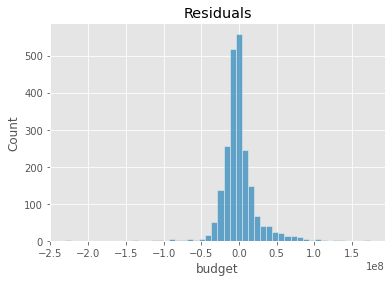

                                                 0
model_name                       Linear_Regression
explained_variance r^2                    0.603962
mean_absolute_error                14976881.369698
mean_squared_error               572000401356765.5
root_mean_squared_error            23916529.876986
mean_absolute_percentage_error            3.315343
model                           LinearRegression()


In [785]:
if continuous:
    # fitting a regression model
    model = LinearRegression(normalize=normalize)
    fit_model(model, 'Linear_Regression', train_X, valid_X, train_y, valid_y)



### Decision Tree

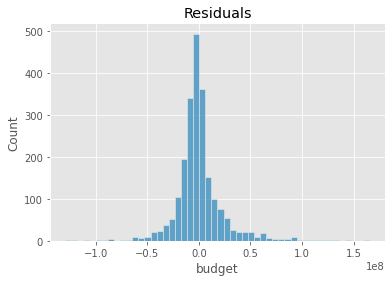

                                                                                0
model_name                                                          Decision_Tree
explained_variance r^2                                                   0.615023
mean_absolute_error                                               14554678.557786
mean_squared_error                                           555922404531149.9375
root_mean_squared_error                                            23578006.79725
mean_absolute_percentage_error                                           3.831587
model                           DecisionTreeRegressor(max_depth=4, min_impurit...


In [786]:
depth = 4
min_split = 20
min_decr = 0.01

if continuous:
    model = DecisionTreeRegressor(max_depth=depth, min_samples_split=min_split, min_impurity_decrease=min_decr)  
else :
    model = DecisionTreeClassifier(max_depth=depth, min_samples_split=min_split, min_impurity_decrease=min_decr)

fit_model(model, 'Decision_Tree', train_X, valid_X, train_y, valid_y)

### Random Forest

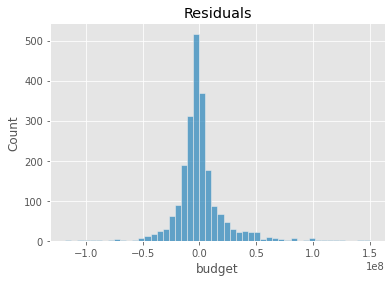

                                                                                0
model_name                                                          Random_Forest
explained_variance r^2                                                   0.664248
mean_absolute_error                                               13282296.908797
mean_squared_error                                           484829046291788.3125
root_mean_squared_error                                           22018833.899455
mean_absolute_percentage_error                                           2.786723
model                           (DecisionTreeRegressor(max_depth=7, max_featur...


In [787]:
depth = 7
n = 100

if continuous:
    model = RandomForestRegressor(n_estimators=n,max_depth=depth)
else: 
    model = RandomForestClassifier(n_estimators=n,max_depth=depth)

fit_model(model, 'Random_Forest', train_X, valid_X, train_y, valid_y)

### AdaBoost

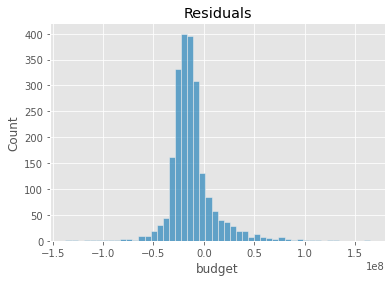

                                                                                0
model_name                                                              Ada_Boost
explained_variance r^2                                                    0.62463
mean_absolute_error                                               20516176.448981
mean_squared_error                                              687021998952692.5
root_mean_squared_error                                           26211104.497001
mean_absolute_percentage_error                                            5.51705
model                           (DecisionTreeRegressor(max_depth=8, random_sta...


In [788]:
depth = 8
n = 100

if continuous:
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=depth), n_estimators=n)
else:
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=n)

fit_model(model, 'Ada_Boost', train_X, valid_X, train_y, valid_y)

### XGBoost

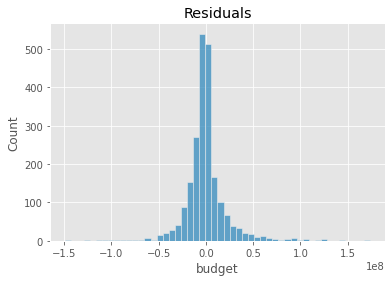

                                                                                0
model_name                                                               XG_Boost
explained_variance r^2                                                   0.635128
mean_absolute_error                                               13505510.766645
mean_squared_error                                           526909921563810.5625
root_mean_squared_error                                           22954518.543498
mean_absolute_percentage_error                                           2.341899
model                           XGBRegressor(base_score=0.5, booster='gbtree',...


In [789]:
gamma = 0.7
use_label_encoder = False

if continuous:
    model = XGBRegressor(gamma=gamma, use_label_encoder=use_label_encoder)
else:
    model = XGBClassifier(use_label_encoder=use_label_encoder)

fit_model(model, 'XG_Boost', train_X, valid_X, train_y, valid_y)

### Gradient Boost

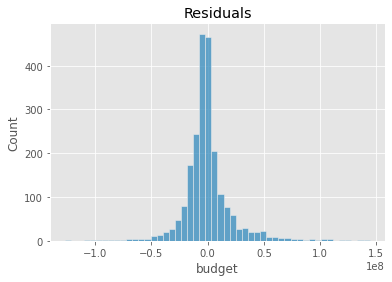

                                                                                0
model_name                                                         Gradient_Boost
explained_variance r^2                                                   0.666955
mean_absolute_error                                               13316306.950997
mean_squared_error                                           480934021802514.8125
root_mean_squared_error                                           21930207.974447
mean_absolute_percentage_error                                           2.500246
model                           ([DecisionTreeRegressor(criterion='friedman_ms...


In [790]:
if continuous:
    model = GradientBoostingRegressor()
else:
    model = GradientBoostingClassifier()

fit_model(model, 'Gradient_Boost', train_X, valid_X, train_y, valid_y)

### Support Vector

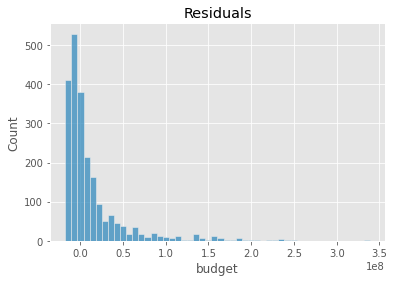

                                                  0
model_name                           Support_Vector
explained_variance r^2                     0.000012
mean_absolute_error                 21136912.342017
mean_squared_error              1603727164669648.75
root_mean_squared_error              40046562.45759
mean_absolute_percentage_error             3.193264
model                                         SVR()


In [791]:

if continuous:
    model = SVR()
else:
    model = SVC()

fit_model(model, 'Support_Vector', train_X, valid_X, train_y, valid_y)

### knn

See [scikit-learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for details on scoring options.

{'n_neighbors': 16, 'weights': 'distance'}


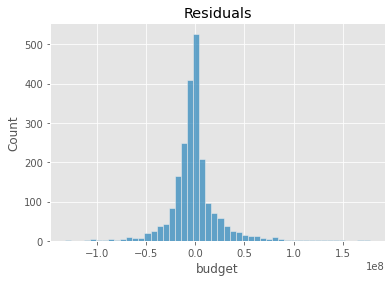

                                                                                0
model_name                                                      kNearest_Neighbor
explained_variance r^2                                                   0.560329
mean_absolute_error                                               15262033.653729
mean_squared_error                                            635324998764943.625
root_mean_squared_error                                           25205654.103096
mean_absolute_percentage_error                                           3.810816
model                           KNeighborsRegressor(n_neighbors=16, weights='d...


In [792]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

grid_params ={'n_neighbors':range(15, 30),
              'weights':['uniform','distance']}
cv = 5 # cross-validation splitting strategy 5-fold cross validation is the default
n_jobs = -1 # number of jobs to run in parallel -1 means use all of your processors

if continuous:
    scoring = 'neg_mean_absolute_percentage_error'
    gs = GridSearchCV(KNeighborsRegressor(),grid_params,cv=cv,n_jobs=n_jobs,scoring=scoring)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    model= gs.best_estimator_

else:
    scoring='accuracy'
    gs = GridSearchCV(KNeighborsClassifier(),grid_params,cv=cv,n_jobs=n_jobs,scoring=scoring)
    gs.fit(train_X,train_y)
    print(gs.best_params_)
    model= gs.best_estimator_


fit_model(model, 'kNearest_Neighbor', train_X, valid_X, train_y, valid_y)

### Neural Net

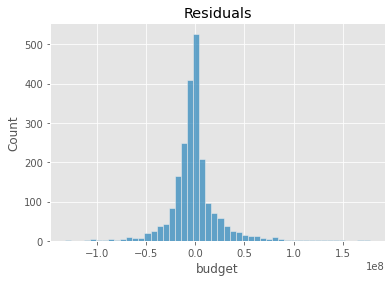

                                                                                0
model_name                                                             Neural_Net
explained_variance r^2                                                   0.560329
mean_absolute_error                                               15262033.653729
mean_squared_error                                            635324998764943.625
root_mean_squared_error                                           25205654.103096
mean_absolute_percentage_error                                           3.810816
model                           KNeighborsRegressor(n_neighbors=16, weights='d...


In [793]:
# Neural net
hidden_layers = 2
activation = 'tanh' #logistic' (sigmoid), 'identity', 'tanh', 'relu'
solver = 'adam' # 'lbfgs', 'sgd', 'adam'
random_state = 1 # default=None
max_iter = 1000 # default=200
alpha = 0.0001 # default=0.0001

if continuous:
    nn = MLPRegressor(hidden_layer_sizes=(hidden_layers), activation=activation, solver=solver, random_state=random_state, max_iter=max_iter, alpha=alpha) 
else:
    nn = MLPClassifier(hidden_layer_sizes=(hidden_layers), activation=activation, solver=solver, random_state=random_state, max_iter=max_iter, alpha=alpha)

fit_model(model, 'Neural_Net', train_X, valid_X, train_y, valid_y)

# Select Model


In [794]:
df_models = pd.DataFrame(all_models).T
df_models.sort_values(by='mean_absolute_percentage_error')


,model_name,explained_variance r^2,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,model
4,XG_Boost,0.635128,13505510.766645,526909921563810.5625,22954518.543498,2.341899,"XGBRegressor(base_score=0.5, booster='gbtree',..."
5,Gradient_Boost,0.666955,13316306.950997,480934021802514.8125,21930207.974447,2.500246,([DecisionTreeRegressor(criterion='friedman_ms...
2,Random_Forest,0.664248,13282296.908797,484829046291788.3125,22018833.899455,2.786723,"(DecisionTreeRegressor(max_depth=7, max_featur..."
6,Support_Vector,0.000012,21136912.342017,1603727164669648.75,40046562.45759,3.193264,SVR()
0,Linear_Regression,0.603962,14976881.369698,572000401356765.5,23916529.876986,3.315343,LinearRegression()
7,kNearest_Neighbor,0.560329,15262033.653729,635324998764943.625,25205654.103096,3.810816,"KNeighborsRegressor(n_neighbors=16, weights='d..."
8,Neural_Net,0.560329,15262033.653729,635324998764943.625,25205654.103096,3.810816,"KNeighborsRegressor(n_neighbors=16, weights='d..."
1,Decision_Tree,0.615023,14554678.557786,555922404531149.9375,23578006.79725,3.831587,"DecisionTreeRegressor(max_depth=4, min_impurit..."
3,Ada_Boost,0.62463,20516176.448981,687021998952692.5,26211104.497001,5.51705,"(DecisionTreeRegressor(max_depth=8, random_sta..."


In [795]:
selected_model = df_models[df_models['model_name'] == 'XG_Boost']['model'].values[0] # select gradient_boost based on lowest mape

# Tune Model

### Make Predictions on Validation Data

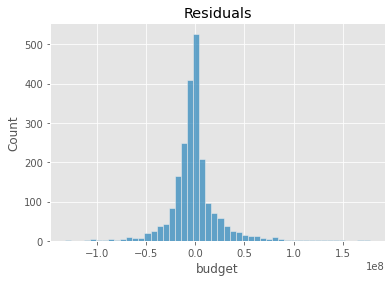

                                                                                0
model_name                                                         Selected_Model
explained_variance r^2                                                   0.560329
mean_absolute_error                                               15262033.653729
mean_squared_error                                            635324998764943.625
root_mean_squared_error                                           25205654.103096
mean_absolute_percentage_error                                           3.810816
model                           KNeighborsRegressor(n_neighbors=16, weights='d...


In [796]:
result = fit_model(model, 'Selected_Model', train_X, valid_X, train_y, valid_y)

# # Use predict() to make predictions on a new set
# selected_model_pred = selected_model.predict(valid_X)
# result = pd.DataFrame({'Predicted': selected_model_pred, 'Actual': valid_y, 'Residual': valid_y - selected_model_pred})

# # print performance measures
# regressionSummary(valid_y, selected_model_pred)

# residual_hist(selected_model, valid_X, valid_y)

# print('First few results')
# print(result.head(20))

# Make a totally new prediction

In [797]:
X.columns

Index(['votes', 'gross_revenue', 'rating_NC-17', 'rating_Not Rated',
       'rating_PG', 'rating_PG-13', 'rating_R', 'rating_TV-MA',
       'rating_Unrated', 'rating_X', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Mystery',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'genre_Western'],
      dtype='object')

In [798]:
# create a movie (in this data a movie can't have more than one rating nor more than one genre)
newMovie = pd.DataFrame([{
    'votes': 100_000, 
    'gross_revenue': 10_000_000, 
    'rating_NC-17': 0, 
    'rating_Not Rated': 0,
    'rating_PG': 0, 
    'rating_PG-13': 1, 
    'rating_R': 0, 
    'rating_TV-MA': 0,
    'rating_Unrated': 0, 
    'rating_X': 0, 
    'genre_Adventure': 0, 
    'genre_Animation': 0,
    'genre_Biography': 0, 
    'genre_Comedy': 1, 
    'genre_Crime': 0, 
    'genre_Drama': 0,
    'genre_Family': 0, 
    'genre_Fantasy': 0, 
    'genre_Horror': 0, 
    'genre_Mystery': 0,
    'genre_Romance': 0, 
    'genre_Sci-Fi': 0, 
    'genre_Thriller': 0, 
    'genre_Western': 0
}])

newMovie_thin = newMovie.loc[:, ~(newMovie == 0).any()]

# predict it's score
print(f'What score do we expect from a new movie with the following features?\n{newMovie_thin.T}\n')
print(f'{outcome_var_name}: {selected_model.predict(newMovie[X.columns])}')


What score do we expect from a new movie with the following features?
                      0
votes            100000
gross_revenue  10000000
rating_PG-13          1
genre_Comedy          1

budget: [11159568.]
